In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')


import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

PATH = '../'
RND_SEED = 44

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

Wall time: 2.58 s


In [61]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs(satellite_predicted_values - satellite_true_values) / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values)))

In [137]:
SAT_ID = ID = np.random.choice(train['sat_id'].unique(), 1)[0] = 90
training_columns = ['sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
prediction_columns = ['x','y','z','Vx', 'Vy', 'Vz']
X = train.loc[:, training_columns]
y = train.loc[:, prediction_columns]
Xtest = test.loc[:, training_columns]

satX = X[X['sat_id'] == SAT_ID].drop(columns = 'sat_id')
satY = y[X['sat_id'] == SAT_ID]
satXTest = Xtest[Xtest['sat_id'] == SAT_ID].drop(columns = 'sat_id')

print(f'ID: {SAT_ID}, Total observations: {satX.shape[0]}; In test {satXTest.shape[0]}')

ID: 90, Total observations: 636; In test 573


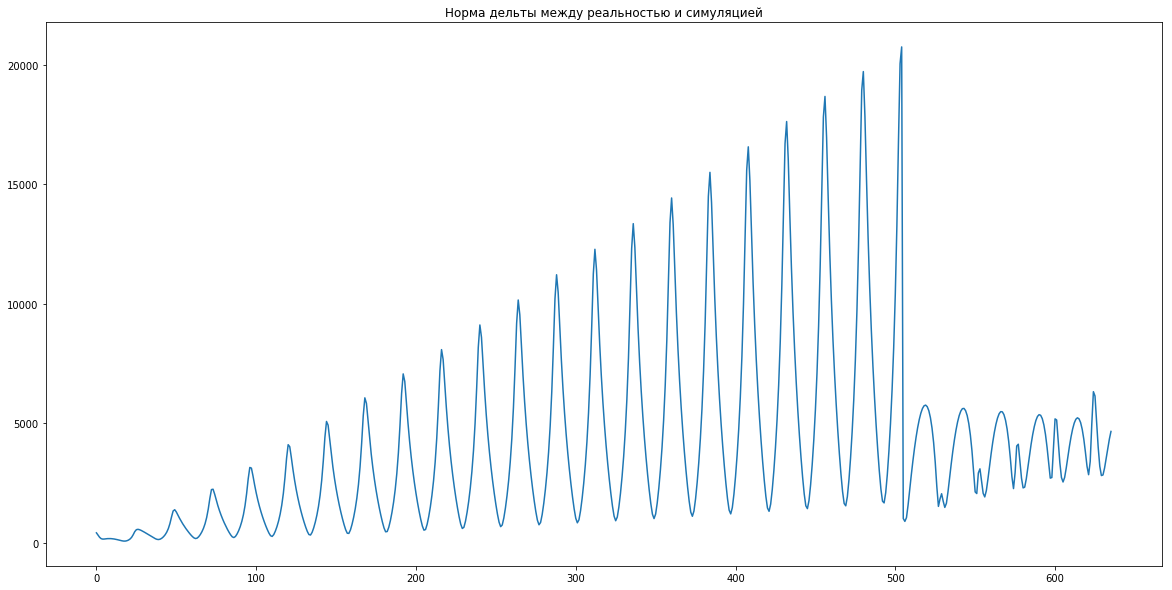

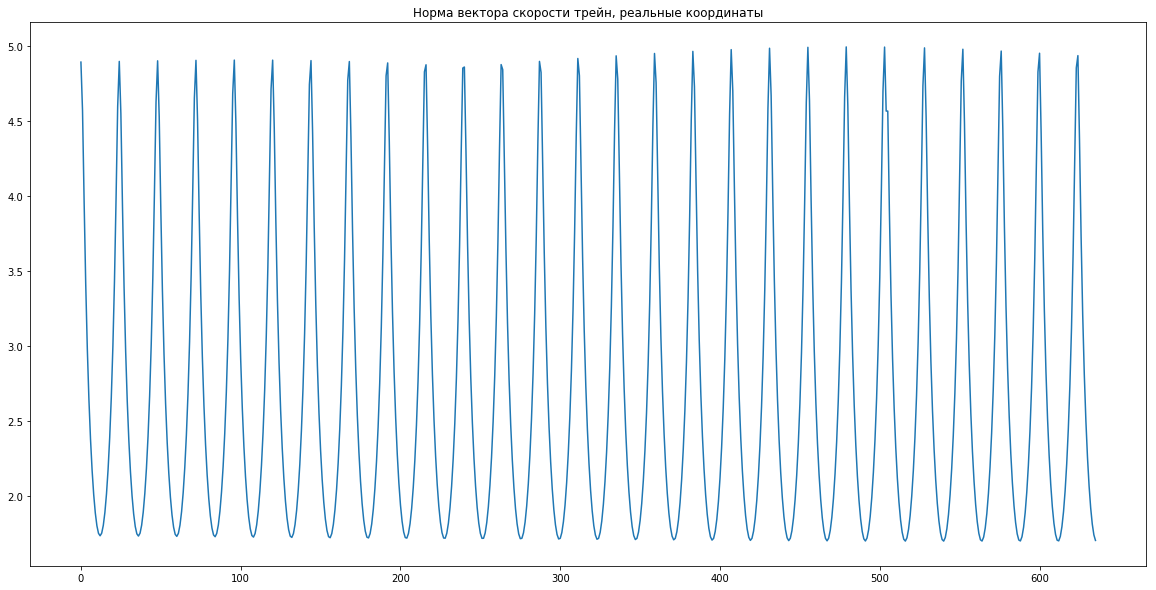

In [138]:
# Зависимость скорости и симулированной скорости от времени

x,y,z = satY.loc[:, 'Vx'].values, satY.loc[:, 'Vy'].values, satY.loc[:, 'Vz'].values
xSim,ySim,zSim = satX.loc[:, 'Vx_sim'].values, satX.loc[:, 'Vy_sim'].values, satX.loc[:, 'Vz_sim'].values

xTestSim, yTestSim, zTestSim = satXTest.loc[:, 'Vx_sim'].values, satXTest.loc[:, 'Vy_sim'].values, satXTest.loc[:, 'Vz_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        #color='rgb(127, 127, 127)',
                        color = np.arange(satTrain.shape[0]),
                        colorscale = 'Viridis',
                        showscale = True,
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')

fig3 = go.Scatter3d(x=xTestSim, 
                    y=yTestSim, 
                    z=zTestSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(255, 87, 123, 0.05)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'SimulatedTest')
fig = go.Figure(data = [fig1, fig2, fig3])
fig.show()


SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['x', 'y', 'z']]
satDataTrainSim = train[train['sat_id'] == SAT_ID].loc[:, ['x_sim', 'y_sim', 'z_sim']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма дельты между реальностью и симуляцией')
plt.plot(np.linalg.norm(satDataTrain.values - satDataTrainSim.values, axis = 1))
plt.show()

SAT_ID = ID
satDataTrain = train[train['sat_id'] == SAT_ID].loc[:, ['Vx', 'Vy', 'Vz']]
#satDataTest = test[test['sat_id'] == SAT_ID].iloc[:, 3:6]
plt.figure(figsize = (20,10))
plt.title('Норма вектора скорости трейн, реальные координаты')
plt.plot(np.linalg.norm(satDataTrain, axis = 1))

In [139]:
# Разобъем на кластеры по x_sim, y_sim, z_sim, кластеров всегда будет 24 (империческое наблюдение так сказать)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
model = KMeans(n_clusters=24, tol = 1e-3, algorithm = 'elkan', random_state=RND_SEED)
#model = DBSCAN(eps = 1000)
labels = model.fit_predict(satX[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']])
print('Num unique labels: ', len(np.unique(labels)))

Num unique labels:  24


In [140]:
# Отобразим все x,y,z, xsim, ysim, zsim, относящиеся к одному кластеру
CLUSTER = 2
CLUSTER2 = 2
CLUSTER3 = 2
CLUSTER4 = 2
clusterDataTrainX = satX[(labels == CLUSTER) | (labels == CLUSTER2) | (labels == CLUSTER3) | (labels == CLUSTER4)]
clusterDataTrainY = satY[(labels == CLUSTER) | (labels == CLUSTER2) | (labels == CLUSTER3) | (labels == CLUSTER4)]
 
testLabels = model.predict(satXTest[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']])
clusterDataTest = satXTest[(testLabels == CLUSTER)| (testLabels == CLUSTER2) | (testLabels == CLUSTER3) | (testLabels == CLUSTER4)]


# Зависимость координат и симулированных координат от времени

x,y,z = clusterDataTrainY.loc[:, 'x'].values, clusterDataTrainY.loc[:, 'y'].values, clusterDataTrainY.loc[:, 'z'].values
xSim,ySim,zSim = clusterDataTrainX.loc[:, 'x_sim'].values, clusterDataTrainX.loc[:, 'y_sim'].values, clusterDataTrainX.loc[:, 'z_sim'].values

xTestSim, yTestSim, zTestSim = clusterDataTest.loc[:, 'x_sim'].values, clusterDataTest.loc[:, 'y_sim'].values, clusterDataTest.loc[:, 'z_sim'].values
fig1 = go.Scatter3d(x=x, 
                    y=y, 
                    z=z, 
                    mode='markers', 
                    marker=dict(
                        #color='rgb(127, 127, 127)',
                        color = np.arange(clusterDataTrain.shape[0]),
                        colorscale = 'Viridis',
                        showscale = True,
                        size=8, 
                        symbol='circle', 
                        line=dict(
                            color='rgb(204, 204, 204)',
                            width=0.5),
                        opacity=0.9),
                   name = 'Real')
fig2 = go.Scatter3d(x=xSim, 
                    y=ySim, 
                    z=zSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(217, 217, 217, 0.14)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'Simulated')

fig3 = go.Scatter3d(x=xTestSim, 
                    y=yTestSim, 
                    z=zTestSim, 
                    mode = 'markers', 
                    marker=dict(
                        size=8,
                        line=dict(
                            color='rgba(255, 87, 123, 0.05)',
                            width=0.5
                        ),
                    opacity=0.8),
                    name = 'SimulatedTest')
fig = go.Figure(data = [fig1, fig2, fig3])
fig.show()

#--------------------------------------------------------------
from sklearn.linear_model import LinearRegression
trainSize = 0.8
nTargets = 6
smp = []
model = LinearRegression()
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:size, :], satY.iloc[size:, :]
for i in range(nTargets):
    model.fit(Xtr, ytr.iloc[:, i])
    ypred = model.predict(Xval)
    smp.append(smape(ypred, yval.iloc[:, i]))
print('Simple LB Score', 100*(1 - np.mean(smp)))

#--------------------------------------------------------------
cluster = KMeans(n_clusters=24, tol = 1e-3, algorithm = 'elkan', random_state=RND_SEED)
labelsTrain = cluster.fit_predict(Xtr)
labelsTest = cluster.predict(Xval)
smp = []
for label in np.unique(labelsTest):
    for i in range(nTargets):
        model.fit(Xtr[labelsTrain == label], ytr[labelsTrain == label].iloc[:, i])
        ypred = model.predict(Xval[labelsTest == label])
        smp.append(smape(ypred, yval[labelsTest == label].iloc[:, i]))
print('Cluster dependent LB Score', 100*(1 - np.mean(smp)))



Simple LB Score 75.51168820252798
Cluster dependent LB Score 71.46226752734412
